# Generating MNIST figures

This notebook allows the creation of the MNIST figures using an existing model.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, optimizers

import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple

from models import NP
import data

In [2]:
FLAGS = {
    "batch_size": 32,
    "iter": int(100000),
    "x_dims": 1,
    "y_dims": 1,
    "max_num_context": 20,
    "latent_dim": 128,
    "lr": 1e-4,
    "amplitude": 1.0,
    "length_scale": 0.4,
    "latent_encoder_arch": [128, 128, 128],
    "deterministic_encoder_arch": None, #[ 128, 128, 128, 128],
    "decoder_arch": [128, 128, 128, 128, 2]
}

t = namedtuple("tuple", FLAGS.keys())

FLAGS = t(**FLAGS)

In [3]:
# Data generator for sampling different images 
# with different context sizes
from tensorflow.keras import datasets

class MNISTDataGen_multiple_context():
    def __init__(self, batch_size, context_nums=[10,100,300,784], testing=False):
        (X_train, _), (X_test, _) = datasets.mnist.load_data()

        if testing:
            self.X = X_test
        else:
            self.X = X_train

        self.X = self.X.astype("float32").reshape(-1, 28 * 28, 1) / 255.

        self.x_values = np.indices((28, 28)).transpose(
            [1, 2, 0]).reshape((-1, 2)).astype("float32")
        self.x_values = np.tile(self.x_values, (batch_size, 1, 1))
        self.x_values = tf.constant(self.x_values)

        self.X = tf.constant(self.X)

        self.x_values = tf.constant(self.x_values)

        self.batch_size = batch_size
        self.context_nums = context_nums
        

    def make_batch(self):
        img_idxs = tf.random.uniform(
            (self.batch_size,), minval=0, maxval=self.X.shape[0], dtype=tf.int32)

        y_values = tf.gather(self.X, img_idxs, axis=0)

        idxs = tf.random.shuffle(np.arange(28 * 28))
        
        context_x_list = []
        context_y_list = []
        
        for num_context in self.context_nums:
            context_x_list += [tf.gather(self.x_values, idxs[:num_context], axis=1)]
            context_y_list += [tf.gather(y_values, idxs[:num_context], axis=1)]

        return (context_x_list, context_y_list), (self.x_values, y_values)

In [4]:
# Training functions

def train_one_step(model, optimizer, batch):
    (context_x, context_y), (target_x, target_y) = batch

    with tf.GradientTape() as tape:
        mu, sigma, _, _, loss = model(
            context_x, context_y, target_x, target_y=target_y)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss

@tf.function
def train(model, optimizer, iterations, dataset_train, dataset_test):
    for it in range(iterations):
        batch = dataset_train.make_batch()
        loss = train_one_step(model, optimizer, batch)
        if it % 10000 == 0:
            (context_x, context_y), (target_x, target_y) = dataset_test.make_batch()
            
            mu, sigma, _, _, loss = model(context_x, context_y, target_x, target_y=target_y)
            tf.print("Iteration", it, "loss", loss)
            #plot_functions(target_x, target_y, context_x, context_y, mu, sigma)

In [5]:
# Setup and loading model

iterations = tf.constant(FLAGS.iter)

dataset_train = data.MNISTDataGen(FLAGS.batch_size, FLAGS.max_num_context)
dataset_test = data.MNISTDataGen(FLAGS.batch_size, FLAGS.max_num_context, testing=True)

latent_encoder_sizes = [int(x) for x in FLAGS.latent_encoder_arch]

if FLAGS.deterministic_encoder_arch is None:
    deterministic_encoder_sizes = None
else:        
    deterministic_encoder_sizes = [int(x) for x in FLAGS.deterministic_encoder_arch]

decoder_sizes = [int(x) for x in FLAGS.decoder_arch]

assert(decoder_sizes[-1] == 2 * FLAGS.y_dims)

model = NP(FLAGS.latent_dim, latent_encoder_sizes, FLAGS.decoder_arch,
           deterministic_encoder_sizes=deterministic_encoder_sizes)

optimizer = optimizers.Adam(FLAGS.lr)

# This is used to initialize the model before loading the weights
# We can also this notebook to train a model by changing 
# the number of iterations
iterations = tf.constant(1)
train(model, optimizer, iterations, dataset_train, dataset_test)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Iteration 0 loss 1.06188059


In [6]:
#model.save_weights('mnist_weights_backup.h5')
model.load_weights('weights/mnist_weights_6mil.h5')

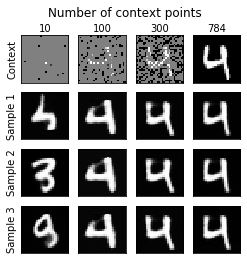

mnist_images/mnist_paper_0.jpg


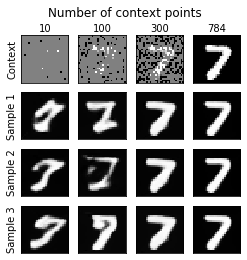

mnist_images/mnist_paper_1.jpg


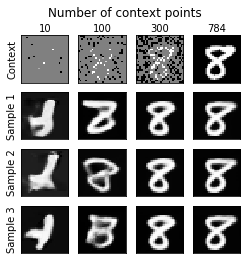

mnist_images/mnist_paper_2.jpg


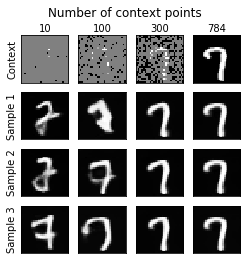

mnist_images/mnist_paper_3.jpg


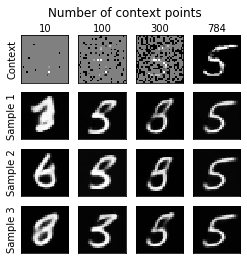

mnist_images/mnist_paper_4.jpg


In [7]:
# Plotting figures

import random

random.seed(0)
tf.random.set_seed(0)

multiple_context_gen = MNISTDataGen_multiple_context(1, context_nums=[10,100,300,784])
(context_x_list, context_y_list), (target_x, target_y) = multiple_context_gen.make_batch()

def plot_mnist_paperstyle(context_x_list, context_y_list,target_x,
                          target_y, model, file_name, save=False):
    
    def add_points_to_img(x_vals,y_vals,img):
        for (x,y), val in zip(x_vals,y_vals):
            img[int(x),int(y)] = val
                
        return img
    
    def plot_single_img(context_x, context_y, target_x, model, num_samples=3):
        
        img = np.zeros((28,28)) + 0.5
        img = add_points_to_img(context_x[0], context_y[0], img)

        axs[0,j].imshow(img, cmap='gray')
        if j == 0:
            axs[0,j].set(ylabel='Context')
        axs[0,j].xaxis.set_label_position('top')
        axs[0,j].set(xlabel=str(context_x[0].shape[0]))
        
        for i in range(num_samples):
            mu, sigma, _, _, loss = model(context_x, context_y, target_x)
            mu, sigma = mu.numpy(), sigma.numpy()
            
            img = add_points_to_img(target_x[0], mu[0], img)

            axs[1+i,j].imshow(img, cmap='gray')
            if j == 0:
                axs[1+i,j].set(ylabel='Sample {}'.format(i+1))
    
    fig, axs = plt.subplots(4, 4) #figsize=(10,10))
    plt.subplots_adjust(left=None, bottom=None, 
                        right=None, top=None, 
                        wspace=-0.65, hspace=None)
    
    for j, (context_x, context_y) in enumerate(zip(context_x_list, context_y_list)):
        plot_single_img(context_x, context_y, target_x, model, num_samples=3)
        
    #for ax in axs.flat:
        #ax.set(xlabel='x-label', ylabel='y-label')
    for ax in axs.flat:
        ax.xaxis.set_ticks_position('top')
        ax.set_xticks([])
        ax.set_yticks([])
     
    fig.suptitle("Number of context points")
    if save:
        plt.savefig(file_name, format='jpg', dpi=600,bbox_inches="tight")
    plt.show()
    
            
for i in range(5):
    file_name = 'mnist_images/mnist_paper_{}.jpg'.format(i)
    (context_x_list, context_y_list), (target_x, target_y) = multiple_context_gen.make_batch()
    plot_mnist_paperstyle(context_x_list, context_y_list,
                          target_x, target_y, model, 
                          file_name=file_name) 
    print(file_name)